In [1]:
import sklearn
import rootutils
import torch_geometric
rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

import matplotlib.pyplot as plt
import torch
import hydra
from topobenchmarkx.data.loaders.graph import *
from topobenchmarkx.data.loaders.hypergraph import *
from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)
import numpy as np
from topobenchmarkx.dataloader import TBXDataloader
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

hydra.initialize(config_path="../configs", job_name="job")

cfg = hydra.compose(config_name="run.yaml", overrides=["model=hypergraph/unignn2","dataset=graph/cocitation_cora" ], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)


dataset, dataset_dir = loader.load()

# Apply transform




processed_dataset = PreProcessor(dataset, dataset_dir, cfg.transforms)

dataset_train, dataset_val, dataset_test = (
        processed_dataset.load_dataset_splits(cfg.dataset.split_params)
    )
    
#data = processed_dataset.data

datamodule = TBXDataloader(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            dataset_test=dataset_test,
            **cfg.dataset.get("dataloader_params", {}),
        )

data = next(iter(datamodule.train_dataloader()))

Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/graph/cocitation/Cora/graph2hypergraph_lifting/2796495657


/tmp/ipykernel_569817/2219630409.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../configs", job_name="job")


In [2]:
data.train_mask.shape

torch.Size([1354])

In [3]:
dtree = sklearn.tree.DecisionTreeClassifier(
    min_samples_leaf=5,
    #min_samples_split=10,
    #max_features='sqrt',
)

x = data.x[data.train_mask].numpy()
y = data.y[data.train_mask].numpy()

dtree.fit(x,y)
dpath = dtree.decision_path(data.x.numpy())

H.shape (2708, 301)


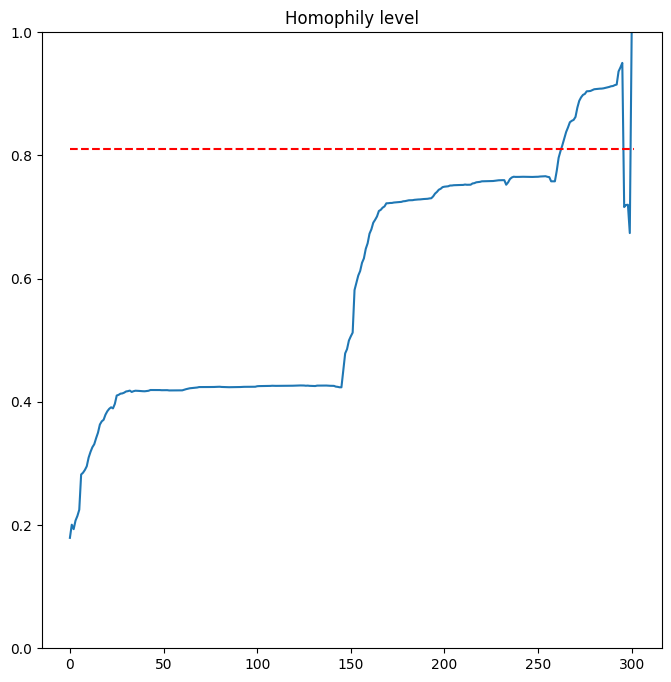

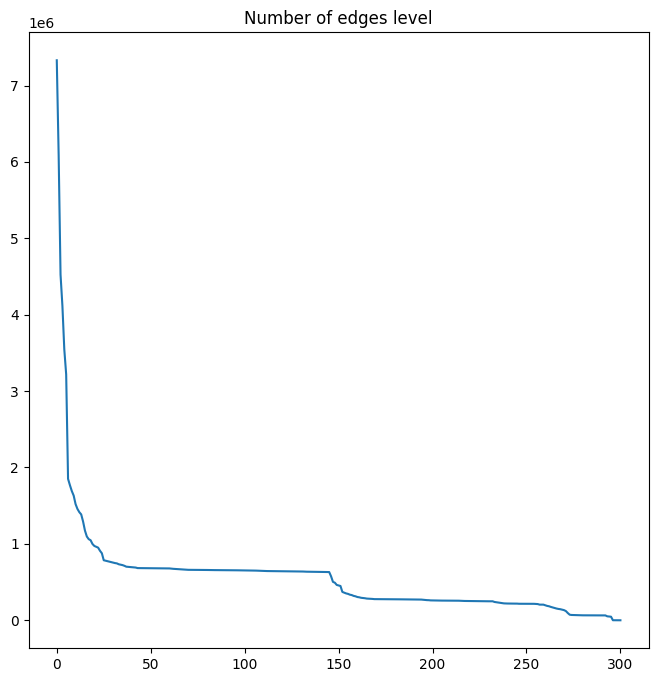

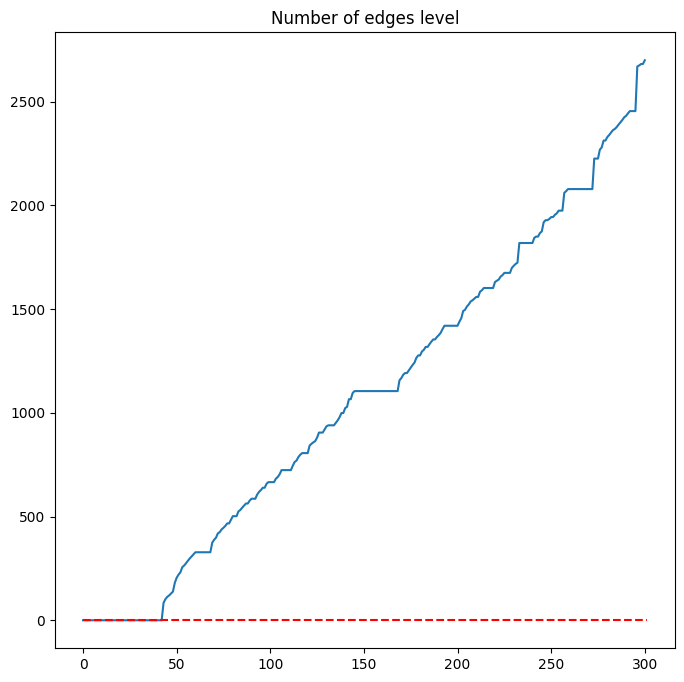

In [ ]:

H = dpath.todense()[:,:]
print('H.shape', H.shape)
sequence, num_edges, num_isolated_nodes = [], [], []
for i in range(0, H.shape[1], 1):
    H_temp = torch.Tensor(H[:,i:])
    A = H_temp @ H_temp.T
    edge_index = (A>0).nonzero().T
    edge_index = torch_geometric.utils.remove_self_loops(edge_index)[0]
    edge_index = torch_geometric.utils.to_undirected(edge_index)
    
    # Statistics    
    num_isolated_nodes.append((A.sum(0)==0).sum())
    num_edges.append(edge_index.shape[1])
    sequence.append(torch_geometric.utils.homophily(edge_index, data.y))
    

plt.plot(sequence)
# Plot red dashed line from one y value
init_homophily = torch_geometric.utils.homophily(data.edge_index, data.y)
plt.plot([0, len(sequence)], [init_homophily, init_homophily], 'r--')
plt.ylim([0, 1])
plt.title('Homophily level')
plt.show()

plt.plot(num_edges)
plt.title('Number of edges level')
plt.show()


plt.plot(num_isolated_nodes)
init_isolated_nodes = (torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0).sum(0)==0).sum()
plt.plot([0, len(num_isolated_nodes)], [init_isolated_nodes, init_isolated_nodes], 'r--')

plt.title('Number of isolated nodes')
plt.show()



tensor(0)

In [111]:
torch_geometric.utils.contains_isolated_nodes(edge_index)

True

In [117]:
A.sum(0)

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [104]:
torch.Tensor(A>0).nonzero().shape[0]

2500

tensor(2658)

In [123]:
A.shape


torch.Size([2708, 2708])